<a href="https://www.kaggle.com/code/mihaail/nist-conv-nn?scriptVersionId=163798965" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch 
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, TensorDataset, DataLoader 
from torchmetrics import Accuracy, MeanAbsoluteError 
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
from torchvision.datasets import MNIST
import torchvision.transforms.v2 as T
from torch.optim.lr_scheduler import StepLR 
import numpy as np

## Первая модель для обучения на датасете MNIST


First model:
  accuracy = 0.992
  loss = 

Second model: accuracy = 0.993
loss = 

### Создаем датасет и даталоадер. 

In [2]:
mnist_train = MNIST(root= "../datasets/mnist", train=True, download=True, transform=T.ToTensor())
 
                   

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


100%|██████████| 9912422/9912422 [00:00<00:00, 96723690.78it/s]


Extracting ../datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 48884460.78it/s]

Extracting ../datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 22571520.78it/s]


Extracting ../datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9261316.85it/s]


Extracting ../datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/mnist/MNIST/raw



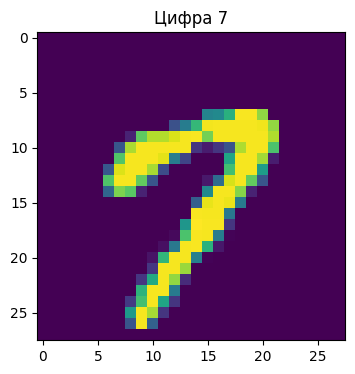

In [3]:
plt.figure(figsize=(5, 4))
plt.title(f'Цифра {mnist_train[15][1]}')
plt.imshow(mnist_train[15][0][0])

plt.show()

In [4]:
mean = (mnist_train.data/255).mean().unsqueeze(0) 
std = (mnist_train.data/255).std().unsqueeze(0) 
print(f'{mean=}') 
print(f'{std=}') 

mean=tensor([0.1307])
std=tensor([0.3081])


In [5]:
train_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=mean, std=std), 
        T.RandomAdjustSharpness(sharpness_factor=2)
    ]
) 

In [6]:
valid_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
        
        
    ]
) 

In [7]:
mnist_train = MNIST(root= "../datasets/mnist", train=True, download=True, transform=train_transforms) 
mnist_valid = MNIST(root= "../datasets/mnist", train=False, download=True, transform=valid_transforms) 

In [8]:
train_loader = DataLoader(mnist_train, batch_size=50, shuffle=True) 
valid_loader = DataLoader(mnist_valid, batch_size=50, shuffle=True) 

## Зададим функции обучения валидации и отрисовки графиков


In [9]:
def train(model: nn.Module,
         loader: DataLoader,
         loss_fn,
         metric) -> tuple[float, float]: 
    
    '''ф-я проводит обучение модели. 
    возвращает ошибку на трейновом датасете'''
    
    model.train()
    total_loss = 0
    total_metric = 0

    for x, y in tqdm(loader, desc="Train"):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad() 
    
        output = model(x) 
    
        loss = loss_fn(output, y) 
        total_loss += loss.item()
        
        loss.backward() 
    
        optimizer.step()
        
        total_metric +=  metric(output.detach(), y).item()
        
    total_loss /= len(loader)
    total_metric /= len(loader) 
    
    return total_loss, total_metric 


@torch.inference_mode() 
def valid(model: nn.Module,
         loader: DataLoader,
         loss_fn,
         metric) -> tuple[float, float] :
    
    '''Ф-я расчитывает ф-ю ошибки и метрику на валидационной выборке'''
    model.eval() 
    
    total_loss = 0
    total_metric = 0
    
    for x, y in tqdm(loader, desc="Evaluation"):
        x, y = x.to(device), y.to(device)
        
        output = model(x) 
        
        loss = loss_fn(output, y) 
        
        total_loss += loss.item()
        
        total_metric += metric(output, y).item() 
        
        
    total_loss /= len(loader)
    total_metric /= len(loader) 
    return total_loss, total_metric
          

def plot_stats(
    train_loss: tuple,
    valid_loss: tuple, 
    train_metric: tuple, 
    valid_metric: tuple, 
    title: str,
    metric_name: str ) :
    '''Ф-я отрисовывает ошибку и метрику на тестовой и трейновой датасетах.
    '''
    plt.figure(figsize=(8, 5))
    plt.title(f'{title} loss') 
    plt.plot(train_loss, label='Train loss') 
    plt.plot(valid_loss, label='Valid loss') 
    
    plt.legend() 
    plt.grid() 
    
    plt.figure(figsize=(8, 5))
    plt.title(f'{title} {metric_name}')
    plt.plot(train_metric, label=f'Train {metric_name}') 
    plt.plot(valid_metric, label=f'Valid {metric_name}') 
    plt.legend() 
    
    plt.grid() 
    
    plt.show() 
    

def train_test_cycle(model: nn.Module,
                    num_epochs: int, 
                    loss_fn, 
                    train_loader: DataLoader, 
                    valid_loader: DataLoader,
                    metric,
                    metric_name: str,
                    title: str,
                    scheduler):
    '''Ф-я проводит для каждой эпох обучение на трейновой выборке, валидацию для валидной выборки
    и отрисовку графиков. '''
    
    train_loss_history, train_metric_history = [], []
    valid_loss_history, valid_metric_history = [], []
    
    
    for epoch in range(num_epochs): 
        train_loss, train_metric = train(model,
                          train_loader, 
                          loss_fn,
                          metric)
        
        valid_loss, valid_metric = valid(model, 
                           valid_loader, 
                           loss_fn, 
                           metric) 
        
        train_loss_history.append(train_loss) 
        valid_loss_history.append(valid_loss) 
        
        train_metric_history.append(train_metric) 
        valid_metric_history.append(valid_metric)
                
        clear_output()
        
        plot_stats(train_loss_history, 
                  valid_loss_history, 
                  train_metric_history, 
                  valid_metric_history, 
                  title,
                  metric_name) 
        
        scheduler.step() 
        print(f'Valid Loss: {valid_loss}') 
        print(f'Valid {metric_name}: {valid_metric}') 
        

### Создаем объект нс

In [10]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [11]:
class FirstModel(nn.Module) :
    def __init__(self) :
        super().__init__() 
        # Размерность входного тензора: 1х28х28
       
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), #16x28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #16x14x14
            nn. Conv2d(in_channels=16, 
                       out_channels=64, 
                       kernel_size=3
                       ), #64X12x12
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2), #64x6x6
            nn.Conv2d(in_channels=64, 
                      out_channels=128, 
                      kernel_size=3, 
                      padding=1), #128x6x6
            
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2), #128x3x3
         
            
            nn.Flatten(), #128x3x3
            nn.Linear(128*3*3, 200), 
            nn.ReLU() , 
            nn.Linear(200, 10) , 
        )
   
    def forward(self, x) :
        return self.net(x) 

### Зададим дополнительные параметры: ф-я потерь, оптимизатор

In [12]:
'''
num_epochs = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
try:
    print(torch.cuda.get_device_name())
except:
    print('GPU нету!')

metric = Accuracy(task='multiclass', num_classes=10).to(device)
metric_name = 'Accuracy'

model = FirstModel().to(device)

title = 'First model'

optimizer = optim.Adam(model.parameters(), lr=1e-3) 

loss_fn = nn.CrossEntropyLoss()

train_test_cycle(model,
                 num_epochs,
                 loss_fn, 
                 train_loader,
                 valid_loader,
                 metric,
                 metric_name,
                 title)
''' 

"\nnum_epochs = 20\n\ndevice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')\n\nprint(device)\ntry:\n    print(torch.cuda.get_device_name())\nexcept:\n    print('GPU нету!')\n\nmetric = Accuracy(task='multiclass', num_classes=10).to(device)\nmetric_name = 'Accuracy'\n\nmodel = FirstModel().to(device)\n\ntitle = 'First model'\n\noptimizer = optim.Adam(model.parameters(), lr=1e-3) \n\nloss_fn = nn.CrossEntropyLoss()\n\ntrain_test_cycle(model,\n                 num_epochs,\n                 loss_fn, \n                 train_loader,\n                 valid_loader,\n                 metric,\n                 metric_name,\n                 title)\n"

In [13]:
class SecondModel(nn.Module) :
    def __init__(self) :
        super().__init__() 
        # Размерность входного тензора: 1х28х28
       
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), #16x28x28
            nn.BatchNorm2d(16), 
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2), #16x14x14
            nn.Dropout2d(p=0.5), 
            
            nn. Conv2d(in_channels=16, 
                       out_channels=64, 
                       kernel_size=3
                       ), #64X12x12
            nn.BatchNorm2d(64), 
            
            nn.ReLU(), 
            
            nn.MaxPool2d(kernel_size=2), #64x6x6
            nn.Dropout2d(p=0.5), 
            
            nn.Conv2d(in_channels=64, 
                      out_channels=128, 
                      kernel_size=3, 
                      padding=1), #128x6x6
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2), #128x3x3
            nn.Dropout2d(p=0.5), 
            
            nn.Flatten(), #128x3x3
            nn.Linear(128*3*3, 200), 
            nn.ReLU() , 
            nn.Linear(200, 10) , 
        )
   
    def forward(self, x) :
        return self.net(x) 

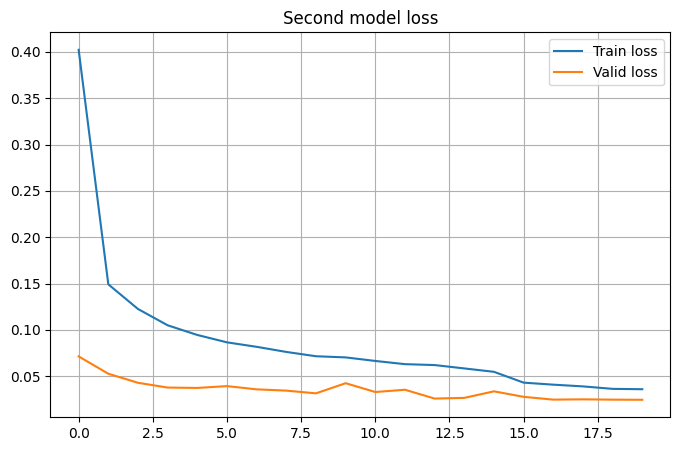

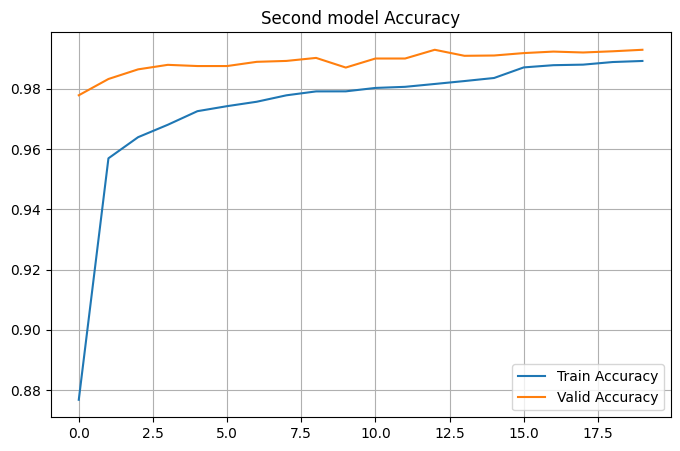

Valid Loss: 0.024587391560354773
Valid Accuracy: 0.9930000039935112


In [14]:
num_epochs = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
try:
    print(torch.cuda.get_device_name())
except:
    print('GPU нету!')

metric = Accuracy(task='multiclass', num_classes=10).to(device)
metric_name = 'Accuracy'

model = SecondModel().to(device)

title = 'Second model'

optimizer = optim.Adam(model.parameters(), lr=1e-3) 

scheduler = StepLR(optimizer, step_size=15) 

loss_fn = nn.CrossEntropyLoss()

train_test_cycle(model,
                 num_epochs,
                 loss_fn, 
                 train_loader,
                 valid_loader,
                 metric,
                 metric_name,
                 title, 
                 scheduler
                )


In [15]:
# Сохранение модели
torch.save(model.state_dict(), f'{title}.pth')

In [16]:
# Загрузка модели
load_model = SecondModel()
load_model.load_state_dict(torch.load(f'{title}.pth'))
load_model.eval()




SecondModel(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.5, inplace=False)
    (5): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.5, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.5, inplace=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(i

In [17]:
'''
input_object = 2
input_tensor = torch.tensor([input_object], dtype=torch.float32)
output_value = load_model(input_tensor).item()
output_value
'''

'\ninput_object = 2\ninput_tensor = torch.tensor([input_object], dtype=torch.float32)\noutput_value = load_model(input_tensor).item()\noutput_value\n'